# Testting integration runtime
---
### Delete upon merge?!

In [1]:
import os
import sys
import torch

# pylint: disable=wrong-import-position
sys.path.append(os.path.realpath('.'))
sys.path.append(os.path.join(os.path.expanduser('~'), 'bnelearn'))

from bnelearn.util.metrics import norm_actions
from bnelearn.util.tensor_util import batched_index_select

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from torchquad import enable_cuda # Necessary to enable GPU support
from torchquad import Simpson, Boole
import torchquad
enable_cuda()


In [34]:
device = 'cuda:0'  # TODO: torchquad cant handle more

# Calculate high precision baseline and write to disk
base_batch_size = 2**12
n_players = 2
prior = torch.distributions.Normal(
    torch.tensor(15.0, device=device),
    torch.tensor(5.0, device=device)
)
prior_cdf = prior.cdf
Fpowered_cpu = lambda v: torch.pow(prior_cdf(torch.tensor(v, device=device)), n_players - 1)
Fpowered = lambda v: torch.pow(prior_cdf(v), n_players - 1)

In [35]:
# # heavy workload
# valuation = prior.sample((base_batch_size,)).relu_()  # TODO torch quad needs non-negative?! 
# baseline_sol = torch.tensor(
#     [integrate.quad(Fpowered_cpu, 0, v)[0] for v in valuation],
#     device=device
# ).view_as(valuation)
# torch.save(baseline_sol, 'baseline_sol.pt')
# torch.save(valuation, 'valuation.pt')

In [36]:
baseline_sol = torch.load('baseline_sol.pt').to(device=device)
valuation = torch.load('valuation.pt').to(device=device)

In [37]:
# Vectorized Simpson's rule
def simpson(x: torch.tensor, fx: torch.tensor) -> torch.tensor:
    """Vectorized Simpson's rule for integration.

    Params:
        :param x: Sampling points for the function values.
        :param fx: Function values at the sampling points.

    Returns:
        :return: Approximation for the integral.
    """
    N = x.shape[-1] - 1
    h = [x[:, [i + 1]] - x[:, [i]] for i in range(0, N)]
    assert N > 0
    assert x.shape[0] == fx.shape[0]

    result = torch.zeros((x.shape[0], 1), device=x.device)
    for i in range(1, N, 2):
        h0, h1 = h[i - 1], h[i]
        hph, hdh, hmh = h1 + h0, h1 / h0, h1 * h0
        result += (hph / 6) * (
            (2 - hdh) * fx[:, [i - 1]] \
            + (hph**2 / hmh) * fx[:, [i]] \
            + (2 - 1 / hdh) * fx[:, [i + 1]]
        )

    if N % 2 == 1:
        h0, h1 = h[N - 2], h[N - 1]
        result += fx[:, [N]] * (2 * h1**2 + 3 * h0 * h1) / (6 * (h0 + h1))
        result += fx[:, [N - 1]] * (h1**2 + 3 * h1 * h0) / (6 * h0)
        result -= fx[:, [N - 2]] * h1**3 / (6 * h0 * (h0 + h1))

    return result

<ipython-input-38-fe7352384e0d>:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  numerator = [integrate.quad(Fpowered_cpu, 0, v)[0] for v in valuation_sample]
/home/kohring/.local/lib/python3.9/site-packages/torchquad/integration/simpson.py:104: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 100 -> 99.
  warnings.warn(


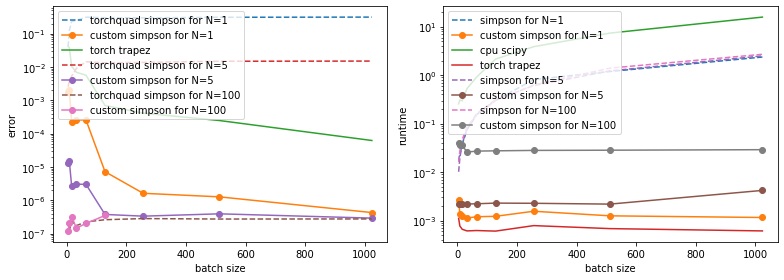

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
Ns = [1, 5, 100]
batch_sizes = [2**x for x in range(2, 11)]

for N in Ns:
    simpson_errors = np.zeros(len(batch_sizes))
    boole_errors = np.zeros(len(batch_sizes))
    scipy_errors = np.zeros(len(batch_sizes))
    custom_errors = np.zeros(len(batch_sizes))
    torch_errors = np.zeros(len(batch_sizes))
    simpson_time = np.zeros(len(batch_sizes))
    boole_time = np.zeros(len(batch_sizes))
    scipy_time = np.zeros(len(batch_sizes))
    custom_time = np.zeros(len(batch_sizes))
    torch_time = np.zeros(len(batch_sizes))

    for i, batch_size in enumerate(batch_sizes):
        valuation_sample = valuation[:batch_size, ...]

        # # tochqaud 1) simpson
        s = time.time()
        simp = Simpson()
        numerator_s = [
            simp.integrate(Fpowered, dim=1, N=N, integration_domain=[[0, v.item()]])
            for v in valuation_sample
        ]
        numerator_s = torch.tensor(numerator_s, device=device).view_as(valuation_sample)
        simpson_errors[i] = norm_actions(numerator_s, baseline_sol[:batch_size, ...])
        simpson_time[i] = time.time() - s

        # # tochqaud 1) boole
        # s = time.time()
        # boole = Boole()
        # numerator_b = [boole.integrate(Fpowered, dim=1, N=N, integration_domain=[[0, v.item()]])
        #     for v in valuation_sample
        # ]
        # numerator_b = torch.tensor(numerator_b, device=device).view_as(valuation_sample)
        # boole_errors[i] = norm_actions(numerator_b, baseline_sol[:batch_size, ...])
        # boole_time[i] = time.time() - s

        # custom
        # PROCEDURE: 1. sort, 2. create N grid sample points inbetween values,
        #            3. approx. integral between sample points, 4. cumsum over
        #            integral values, 5. restore original order
        s = time.time()
        v, sort_idx = valuation_sample.view(1, -1).sort()
        v = v.squeeze()
        lower_bound = torch.cat([torch.tensor([0], device=device), v[:-1]])
        v_int = torch.cat(
            [
                lower_bound.view(-1, 1),
                torch.zeros((v.shape[0], N), device=device),
                v.view(-1, 1)
            ],
            axis=1)
        for n in range(1, N+1):
            v_int[:, n] = v_int[:, 0] + (n / (N + 1)) * (v_int[:, -1] - v_int[:, 0])
        F = Fpowered(v_int)
        # clean up: currently the reorder with gather needs an artifical 2nd dim
        numerator_b = torch.cumsum(
            simpson(v_int, F), 0).view(1, -1).gather(1, sort_idx.argsort(1)).squeeze()
        custom_errors[i] = norm_actions(numerator_b, baseline_sol[:batch_size, ...])
        custom_time[i] = time.time() - s

        # pytorch trapez rule
        s = time.time()
        v, sort_idx = valuation_sample.view(1, -1).sort()
        v = v.squeeze()
        lower_bound = torch.cat([torch.tensor([0], device=device), v[:-1]])
        v_int = torch.cat(
            [
                lower_bound.view(-1, 1),
                torch.zeros((v.shape[0], N), device=device),
                v.view(-1, 1)
            ],
            axis=1)
        for n in range(1, N+1):
            v_int[:, n] = v_int[:, 0] + (n / (N + 1)) * (v_int[:, -1] - v_int[:, 0])
        F = Fpowered(v_int)
        numerator_b = torch.cumsum(
            torch.trapz(F, v_int), 0).view(1, -1).gather(1, sort_idx.argsort(1)).squeeze()
        torch_errors[i] = norm_actions(numerator_b, baseline_sol[:batch_size, ...])
        torch_time[i] = time.time() - s

        if N == Ns[0]:
            # scipy integration
            s = time.time()
            numerator = [integrate.quad(Fpowered_cpu, 0, v)[0] for v in valuation_sample]
            numerator = torch.tensor(numerator, device=device).view_as(valuation_sample)
            # scipy_errors[i] = norm_actions(numerator, baseline_sol[:batch_size, ...])
            scipy_time[i] = time.time() - s
        
    axs[0].plot(batch_sizes, simpson_errors, '--', label=f'torchquad simpson for N={N}')
    # axs[0].plot(batch_sizes, boole_errors, label=f'boole for N={N}')
    axs[0].plot(batch_sizes, custom_errors, 'o-', label=f'custom simpson for N={N}')
    axs[0].plot(batch_sizes, torch_errors, label=f'torch trapez for N={N}')
    axs[1].plot(batch_sizes, simpson_time, '--', label=f'simpson for N={N}')
    # axs[1].plot(batch_sizes, boole_time, label=f'boole for N={N}')
    axs[1].plot(batch_sizes, custom_time, 'o-', label=f'custom simpson for N={N}')
    axs[1].plot(batch_sizes, torch_time, label=f'torch trapez for N={N}')
    if N == Ns[0]:
        axs[1].plot(batch_sizes, scipy_time, label=f'cpu scipy')
axs[0].legend(loc='upper left')
axs[0].set_xlabel('batch size')
axs[0].set_yscale('log')
axs[0].set_ylabel('error')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('batch size')
axs[1].set_ylabel('runtime')
axs[1].set_yscale('log')
plt.tight_layout()
plt.show()